<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/Attention_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install torchcontrib

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [19]:
train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
train['DateTime'] = pd.to_datetime(train.DateTime)
train['Date'] = train.DateTime.dt.date
train['DayOfWeek'] = (train.DateTime.dt.weekday)/6

train['DayOfMon'] = ((train.DateTime).dt.day)/31
train['WeekOfYear'] = ((train.DateTime).dt.weekofyear)/40
train['Days'] = (train.DateTime.max() - train.DateTime).dt.days + 1
right = train.iloc[:,5:].groupby(train['Date']).mean().reset_index()
left = train.iloc[:,:5].groupby(train['Date']).sum().reset_index()
train  = pd.merge(left, right, on='Date')

def log_trans(x):
  return np.log(1+x)

train['Days'] = log_trans(train['Days'])


# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()
    
    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  log_trans(train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  log_trans(train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = log_trans(train[target].cumsum())
    train[target] = log_trans(train[target])
    
train = train.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


# 변수별로 다른 vector query 이용

In [20]:
def make_data(df, window_size=180):
  # in 180
  input_window = window_size
  # out 61 
  output_window = 61

  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 4))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window    
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 5].values


  return window_x, window_y

In [111]:
class DatasetWindows(Dataset):
  def __init__(self, df):
    x, y = make_data(df)

    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
   
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    return self.x[idx,...], self.y[idx,...]

In [157]:
class LSTMConv(nn.Module):
    def __init__(self):
        super(LSTMConv, self).__init__()
        self.embedding = nn.Sequential(nn.Linear(48, 32),
                                       nn.Dropout(0.8),
                                       nn.ReLU())

        self.LSTM = nn.Sequential(nn.LSTM(input_size = 180,
                            hidden_size = 128,
                            num_layers=1,
                            batch_first=True))
        
        
        # B x 32 x 90 -> B x 4 x 61
        self.conv = nn.Conv1d(32, 4, 8, 2)
        self.last = nn.Linear(32, 4)
        
    def forward(self, x_time):

        x_time = self.embedding(x_time)
        x_time,_ = self.LSTM(x_time.transpose(-2,-1))
        #B x 4 x 61
        x_time = self.conv(x_time)
        #B x 61 x 4
        x_time = x_time.transpose(-2,-1)
        
        return x_time

In [161]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()

        self.embedding = nn.Sequential(nn.Linear(48, 32),
                                       nn.Dropout(0.8),
                                       nn.ReLU())
        
        self.LSTM = nn.Sequential(nn.LSTM(input_size = 180,
                            hidden_size = 90,
                            num_layers=1,
                            batch_first=True))
        
        self.last = nn.Sequential(nn.Linear(32, 4))
    
    def forward(self, x_time):
        x_time = self.embedding(x_time)
        x_time,_ = self.LSTM(x_time.transpose(-2,-1))
        x_time = x_time[...,-61:]
        x_time = x_time.transpose(-2,-1)
        out_time = self.last(x_time)
        
        return out_time

In [163]:
class ModelManager():
  def __init__(self, model_name, df, device='gpu', cv=50):
    super(ModelManager, self).__init__()
    self.cv = cv
    # CV 구현..
    self.models = []
    self.dataloders = []
    
    for i in range(cv):  
      model =  model_name()
      if device == 'gpu':
        model =  model.cuda()
      self.models.append(model)

      cv_set = df
      dataset = DatasetWindows(cv_set)
      self.dataloders.append(DataLoader(dataset, batch_size=30,  num_workers=0, pin_memory=False,
                                        shuffle=True))
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss


    for i in tqdm(range(self.cv)):  
      # Train model
      model = self.models[i]
      dataloader = self.dataloders[i]
      adam =  torch.optim.Adam(model.parameters(), lr=lr)
      optimizer = SWA(adam, swa_start=10, swa_freq=5, swa_lr=lr/2)
      criterion = nn.MSELoss(size_average = True)

      for epoch in range(num_epochs):
          for data in dataloader:
              x, y = data
              train_pred = model(x)
              loss = criterion(train_pred, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if epoch % 100 == 99:
            if log:
              if val_set.any().any():
                val_loss = get_val_loss()
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
              else: 
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")
      


  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return (np.exp(x)-1).astype(np.int64)
  

  def predict(self, df):

    last_observe = df.iloc[-180:,1:]
    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    inp_tensor = inp_tensor.unsqueeze(0)

    model = self.models[0].eval()
    prediction = model(inp_tensor)
    self.models[0] = model.train()

    for i in range(1, self.cv): 
      model = self.models[i].eval()
      prediction += model(inp_tensor)
      self.models[i] = model.train()
    
    prediction /= self.cv
    return  self.inverse_log(prediction.cpu().detach().squeeze().numpy())

  def make_val_plot(self, val_df, train_df, get_loss=False):
    #predict
    pred = self.predict(train_df)
    label = self.inverse_log(val_df)

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

In [ ]:
# train val split
train_whole = train
train_split = train[:-61]
val = train.iloc[-61:, 1:5]

simple = ModelManager(SimpleLinear, train_split, cv=1)
simple.fit(num_epochs=2000, lr=1e-3, log=True, val_set=val, train_set=train_split)

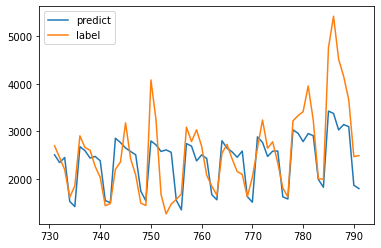

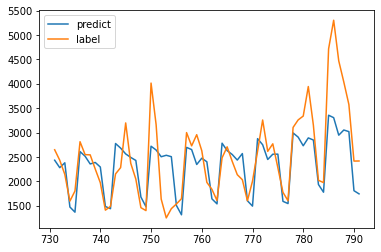

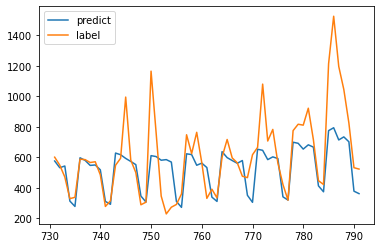

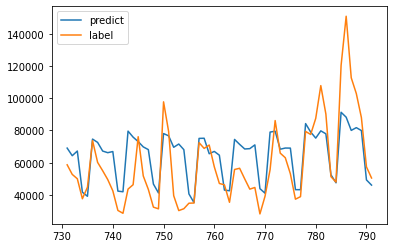

RMSE : 2.6155740304560857


In [165]:
simple.make_val_plot(val, train_split)